In [0]:
import tensorflow as tf
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive/')
data_path = f'/content/gdrive/My Drive/Object Localization'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
def getBB(file):
  
  #parse the annotations
  path = data_path + f'/annotations/xmls/{file}'
  tree = ET.parse(path)
  root = tree.getroot()
  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text

  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text

  return((int(xmin), int(ymin)), (int(xmax), int(ymax)))

def drawBB(file):
  #draw the bounding box
  img_path = data_path + f'/images/{file[:-4]}.jpg' 
  img = cv2.imread(img_path)
  
  (xmin, ymin), (xmax, ymax) = getBB(file)

  print(getBB(file))
  annotated = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  
  plt.figure(figsize=(9,9))
  plt.imshow(annotated[:,:,::-1])
  plt.axis('off')
  plt.show()

((119, 29), (221, 143))


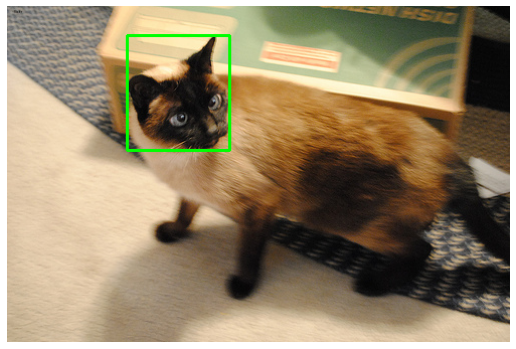

In [0]:
file = np.random.choice(os.listdir(data_path + f'/annotations/xmls'))
drawBB(file)

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
      img_path = data_path + f'/images/{f[:-4]}.jpg'
      img = Image.open(img_path)
      w,h = img.size
      
      img = img.resize(sz)
      (xmin, ymin), (xmax, ymax) = getBB(f)
      
      img = np.array(img).astype('float32')
      if len(img.shape) == 2:
        img = np.stack((img,)*3, axis=-1)

      else:
        img = img[:,:,0:3]
      
      box = np.array([xmin/w, ymin/h, xmax/w, ymax/h])

      batch_x.append(img/255)
      batch_y.append(box)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir(data_path + f'/annotations/xmls')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
train_generator = image_generator(train_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))
test_generator  = image_generator(test_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))

Size of training  3501
Size of testing   185


In [0]:
x, y = next(train_generator)

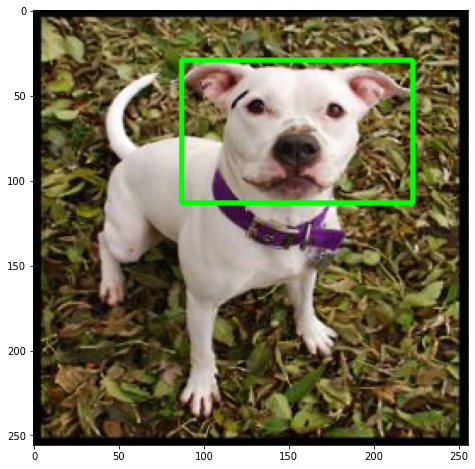

In [0]:
img = (x[0] * 255).astype('uint8')
box = y[0]
box = [int(IMG_SIZE *i) for i in box]

annotated = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.figure(figsize=(8,8))
plt.imshow(annotated)



```
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir(data_path + f'/annotations/xmls')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
```

```
def append_ext(file):
    return file[:-4] + ".jpg"

traindf = pd.DataFrame()
traindf['id'] = train_files
# traindf["label"] = traindf["id"].apply(getBB)
# traindf["id"] = traindf["id"].apply(append_ext)

testdf = pd.DataFrame()
testdf['id'] = test_files
# testdf["label"] = testdf["id"].apply(getBB)
# testdf["id"] = testdf["id"].apply(append_ext)
```

```

# Using ImageDataGenerator to read images from directories
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

data_dir = data_path + f'/images'
train_generator = train_datagen.flow_from_dataframe(dataframe=traindf,
                                                    directory=data_dir,
                                                    x_col="id",
                                                    y_col="label",
                                                    target_size=(150, 150), # Resizes all images to 150 × 150
                                                    batch_size=20,
                                                    class_mode='binary') # Class mode needs to be changed

test_generator = test_datagen.flow_from_dataframe(dataframe=testdf,
                                                  directory=data_dir,
                                                  x_col="id",
                                                  y_col="label",
                                                  target_size=(150, 150), # Resizes all images to 150 × 150
                                                  batch_size=20,
                                                  class_mode='binary')
```





# Evaluation Metric

https://datascience.stackexchange.com/questions/13746/how-to-define-a-custom-performance-metric-in-keras

https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [0]:
def iou(boxA, boxB):
  
  #evaluate the intersection points 
  xA = np.maximum(boxA[:, 0], boxB[:, 0])
  yA = np.maximum(boxA[:, 1], boxB[:, 1])

  xB = np.minimum(boxA[:, 2], boxB[:, 2])
  yB = np.minimum(boxA[:, 3], boxB[:, 3])

  # compute the area of intersection rectangle
  interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
  boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return tf.reduce_mean(np.mean(interArea / unionArea))

# Create the Model

In [0]:
model = models.Sequential()
model.add(Conv2D(16, (3, 3), padding = 'same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding = 'same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)      

In [0]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [])

#create a checkpoint for the best model 
model_save = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou', mode='max', save_weights_only= True, verbose = 0)

# Training

https://www.kaggle.com/vbookshelf/keras-iou-metric-implemented-without-tensor-drama

https://stackoverflow.com/questions/54103770/object-localization-keras-predicts-the-whole-image

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

history = model.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = train_steps,
                              validation_data = test_generator,
                              validation_steps = test_steps,
                              callbacks=[model_save])

# Prediction

In [0]:
#load the best model 
model.load_weights('best_model.h5')

In [0]:
x,y = next(test_generator)
img = x[0]
box = model.predict(np.expand_dims(img, 0))[0]
box = [int(IMG_SIZE*i) for i in box]
annotated = cv2.rectangle((img*255) , (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
box = [int(IMG_SIZE * i) for i in y[0]]
annotated = cv2.rectangle((annotated) , (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.axis('off')
plt.imshow((annotated ).astype('uint8'))